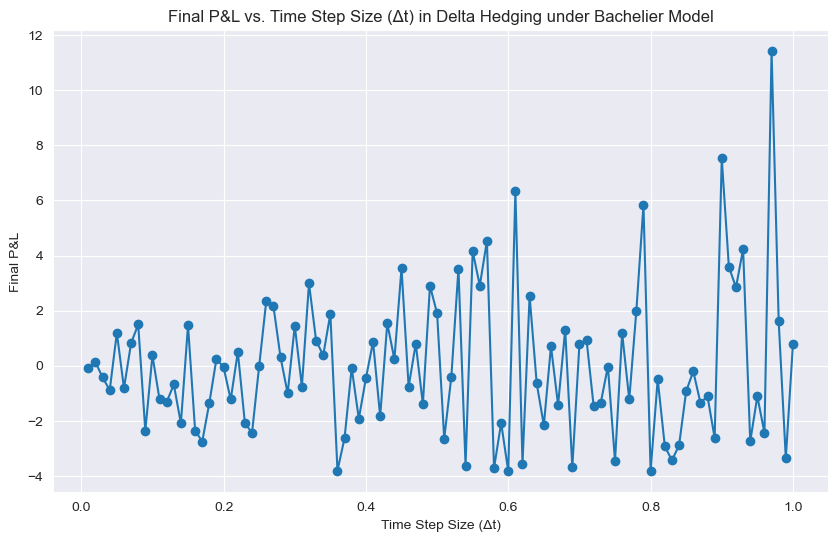

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S0 = 100         # Initial stock price
K = 100          # Strike price
sigma = 10       # Volatility in Bachelier model
T = 1.0          # Time to maturity in years
r = 0.0          # Risk-free rate
np.random.seed(42)  # For reproducibility

# Delta t values from 0.01 to 1
delta_t_values = np.linspace(0.01, 1.0, 100)

# Initialize array to store final P&L
final_pnl = []

# Option pricing and Greeks under Bachelier model
def bachelier_option_price(S, K, sigma, T, option_type='call'):
    d = (S - K) / (sigma * np.sqrt(T))
    if option_type == 'call':
        price = (S - K) * norm.cdf(d) + sigma * np.sqrt(T) * norm.pdf(d)
    else:
        price = (K - S) * norm.cdf(-d) + sigma * np.sqrt(T) * norm.pdf(-d)
    return price

def bachelier_delta(S, K, sigma, T):
    d = (S - K) / (sigma * np.sqrt(T))
    delta = norm.cdf(d)
    return delta

def bachelier_gamma(S, K, sigma, T):
    d = (S - K) / (sigma * np.sqrt(T))
    gamma = norm.pdf(d) / (sigma * np.sqrt(T))
    return gamma

# Simulate Bachelier dynamics and delta hedging for each delta_t
for delta_t in delta_t_values:
    N = int(T / delta_t)
    dt = T / N
    time_grid = np.linspace(0, T, N+1)
    
    # Simulate stock price path
    Z = np.random.randn(N)
    S = np.zeros(N+1)
    S[0] = S0
    for t in range(1, N+1):
        S[t] = S[t-1] + sigma * np.sqrt(dt) * Z[t-1]
    
    # Initialize arrays
    delta = np.zeros(N+1)
    holdings = np.zeros(N+1)
    cash = np.zeros(N+1)
    option_value = np.zeros(N+1)
    
    # Initial option price and delta
    option_value[0] = bachelier_option_price(S[0], K, sigma, T, 'call')
    delta[0] = bachelier_delta(S[0], K, sigma, T)
    holdings[0] = -delta[0]
    cash[0] = option_value[0] + holdings[0] * S[0]
    
    for t in range(1, N+1):
        # Time remaining
        tau = T - time_grid[t]
        if tau <= 0:
            tau = 1e-10  # Avoid division by zero
        
        # Option value
        option_value[t] = bachelier_option_price(S[t], K, sigma, tau, 'call')
        
        # Compute delta
        delta[t] = bachelier_delta(S[t], K, sigma, tau)
        
        # Rebalance hedge at every time step
        holdings[t] = -delta[t]
        
        # Update cash position
        cash[t] = cash[t-1] * np.exp(r * dt) - (holdings[t] - holdings[t-1]) * S[t]
    
    # Final portfolio P&L
    portfolio = option_value + holdings * S + cash
    pnl = portfolio - portfolio[0]
    final_pnl.append(pnl[-1])

# Plotting final P&L vs delta_t
plt.figure(figsize=(10, 6))
plt.plot(delta_t_values, final_pnl, marker='o')
plt.xlabel('Time Step Size (Δt)')
plt.ylabel('Final P&L')
plt.title('Final P&L vs. Time Step Size (Δt) in Delta Hedging under Bachelier Model')
plt.grid(True)
plt.show()


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S0 = 100         # Initial stock price
K = 100          # Strike price
sigma = 10       # Volatility in Bachelier model
T = 1.0          # Time to maturity in years
r = 0.0          # Risk-free rate

delta_t_values = np.linspace(0.01, 1.0, 100)  # From 0.01 to 1.0, 100 points
M = 1000  # Number of Monte Carlo simulations for each delta_t

# Option pricing and Greeks under Bachelier model
def bachelier_option_price(S, K, sigma, T, option_type='call'):
    d = (S - K) / (sigma * np.sqrt(T))
    if option_type == 'call':
        price = (S - K) * norm.cdf(d) + sigma * np.sqrt(T) * norm.pdf(d)
    else:
        price = (K - S) * norm.cdf(-d) + sigma * np.sqrt(T) * norm.pdf(-d)
    return price

def bachelier_delta(S, K, sigma, T):
    d = (S - K) / (sigma * np.sqrt(T))
    delta = norm.cdf(d)
    return delta

def bachelier_gamma(S, K, sigma, T):
    d = (S - K) / (sigma * np.sqrt(T))
    gamma = norm.pdf(d) / (sigma * np.sqrt(T))
    return gamma

mean_pnl = []
std_pnl = []

# Main loop over delta_t values
for delta_t in delta_t_values:
    N = int(T / delta_t)
    dt = T / N
    time_grid = np.linspace(0, T, N+1)
    
    pnl_simulations = []
    
    for m in range(M):
        # Simulate stock price path
        Z = np.random.randn(N)
        S = np.zeros(N+1)
        S[0] = S0
        for t in range(1, N+1):
            S[t] = S[t-1] + sigma * np.sqrt(dt) * Z[t-1]
        
        # Initialize arrays
        delta = np.zeros(N+1)
        holdings = np.zeros(N+1)
        cash = np.zeros(N+1)
        option_value = np.zeros(N+1)
        
        # Initial option price and delta
        option_value[0] = bachelier_option_price(S[0], K, sigma, T, 'call')
        delta[0] = bachelier_delta(S[0], K, sigma, T)
        holdings[0] = -delta[0]
        cash[0] = option_value[0] + holdings[0] * S[0]
        
        for t in range(1, N+1):
            # Time remaining
            tau = T - time_grid[t]
            if tau <= 0:
                tau = 1e-10  # Avoid division by zero
            
            # Option value
            option_value[t] = bachelier_option_price(S[t], K, sigma, tau, 'call')
            
            # Compute delta
            delta[t] = bachelier_delta(S[t], K, sigma, tau)
            
            # Rebalance hedge at every time step
            holdings[t] = -delta[t]
            
            # Update cash position
            cash[t] = cash[t-1] * np.exp(r * dt) - (holdings[t] - holdings[t-1]) * S[t]
        
        # Final portfolio P&L
        portfolio = option_value + holdings * S + cash
        pnl = portfolio[-1] - portfolio[0]
        pnl_simulations.append(pnl)
    
    # Compute mean and standard deviation of P&L for this delta_t
    mean_pnl.append(np.mean(pnl_simulations))
    std_pnl.append(np.std(pnl_simulations))


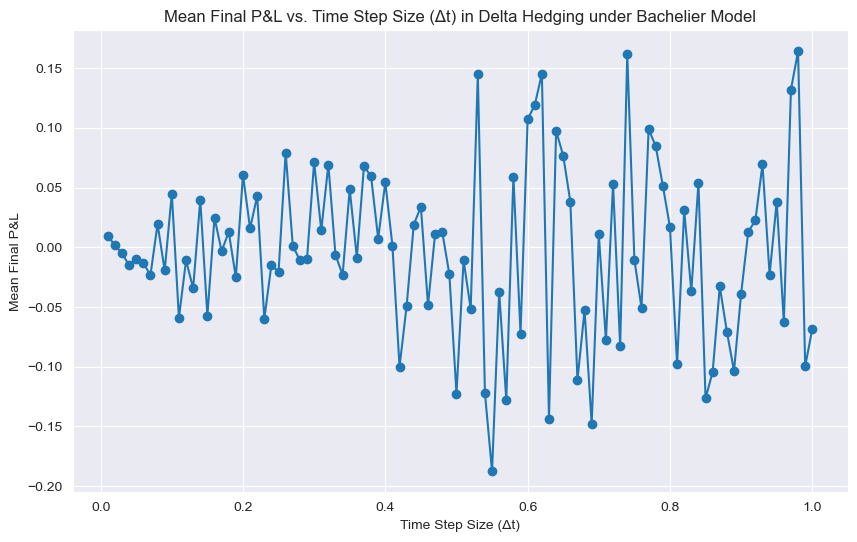

In [71]:

# Plotting mean final P&L vs delta_t
plt.figure(figsize=(10, 6))
plt.plot(delta_t_values, mean_pnl, marker='o')
plt.xlabel('Time Step Size (Δt)')
plt.ylabel('Mean Final P&L')
plt.title('Mean Final P&L vs. Time Step Size (Δt) in Delta Hedging under Bachelier Model')
plt.grid(True)
plt.show()